# Does traditional features improve SotA CNNs?
- # Dataset: ISIC2017
- # CNN: se_resnext50

In [1]:
#import numpy as np 
#import pandas as pd
import PIL
import skimage.feature
import sklearn
import torch
import fastai
import pretrainedmodels

from tqdm import tqdm_notebook
from fastai import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold

packages = [
  ["Numpy",         np.__version__,        "Numbers"],
  ["Pandas",        pd.__version__,        "Data manipulation"],
  ["Pillow",        PIL.__version__,       "Image"],
  ["Skimage",       skimage.__version__,   "Image"],
  ["Scikit-learn",  sklearn.__version__,   "Machine learning"],
  ["Pytorch",       torch.__version__,     "Low level deep learning"],
  ["Fast.ai",       fastai.__version__,    "High level deep learning"],
  ["Cadene", pretrainedmodels.__version__, "Pretrained deep learning models"]]

new_df = pd.DataFrame(columns=["Package", "Version", "Description"], data=packages)
new_df.style.set_properties(**{'text-align': 'left'})

,Package,Version,Description
0,Numpy,1.15.4,Numbers
1,Pandas,0.24.2,Data manipulation
2,Pillow,5.4.1,Image
3,Skimage,0.14.2,Image
4,Scikit-learn,0.20.1,Machine learning
5,Pytorch,1.0.1,Low level deep learning
6,Fast.ai,1.0.51,High level deep learning
7,Cadene,0.7.4,Pretrained deep learning models


# Data

In [2]:
#TASK = "melanoma"
TASK = "seborrheic_keratosis"

path     = pathlib.Path("E:/Datasets/TFM/ISIC-2017")
df_train = pd.read_csv(path / "ground_truth_train.csv")
df_valid = pd.read_csv(path / "ground_truth_valid.csv")
df_test  = pd.read_csv(path / "ground_truth_test.csv")
df_train[["melanoma", "seborrheic_keratosis"]] = df_train[["melanoma", "seborrheic_keratosis"]].astype(int)
df_valid[["melanoma", "seborrheic_keratosis"]] = df_valid[["melanoma", "seborrheic_keratosis"]].astype(int)
df_test[ ["melanoma", "seborrheic_keratosis"]] = df_test[ ["melanoma", "seborrheic_keratosis"]].astype(int)

df_train_meta = pd.read_csv(path / "data_train" / "ISIC-2017_Training_Data_metadata.csv")
df_valid_meta = pd.read_csv(path / "data_valid" / "ISIC-2017_Validation_Data_metadata.csv")
df_valid_meta = pd.read_csv(path / "data_test"  / "ISIC-2017_Test_v2_Data_metadata.csv")

df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


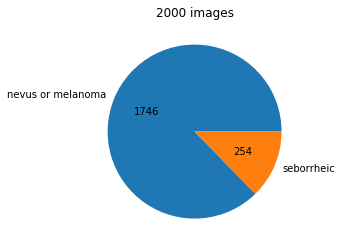

In [3]:
pct = lambda p: '{:.0f}'.format(p * 2000 / 100)
labels = ["nevus or melanoma", 'seborrheic']
df_train[TASK].value_counts().plot.pie(labels=labels, autopct=pct); plt.ylabel(''); plt.title('2000 images');

In [4]:
###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df_train.image_id.values
y = df_train.melanoma.values
train_idxs_fold = []
valid_idxs_fold = []

cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)
    
##################################### Src data
src_train = ImageList.from_df(df_train, path, folder='data_train', suffix=".jpg")
src_valid = ImageList.from_df(df_valid, path, folder='data_valid', suffix=".jpg")
src_test  = ImageList.from_df(df_test,  path, folder='data_test',  suffix=".jpg")

data = (src_train.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0]) # src_train.no_split(); src.valid = valid
        .label_from_df(cols=TASK)
        .transform(get_transforms(flip_vert=True, max_warp=None), size=224)#512)
        .databunch(bs=16)
        .normalize(imagenet_stats))

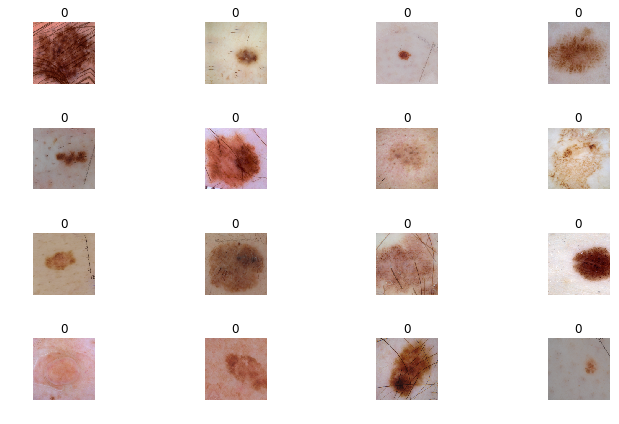

In [5]:
data.show_batch(rows=4, figsize=(10,6))

## Add AUC metric

In [5]:
##################################################### Fastai AUC ROC chapuza
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return sklearn.metrics.roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])

## Choose a pretrained model

In [6]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [7]:
def cadene_model(model_name):
    def mymodel(pretrained=True, **kwargs):
        return pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    return mymodel

#model = models.resnet34 # models.resnet50
model = cadene_model('se_resnext50_32x4d')                                     # this returns a function
learn = cnn_learner(data, model, metrics=accuracy, callback_fns=AUROC, cut=-2) # cut parameter is different for each model
#print(learn.summary())

## Balance loss function (class-weighted CrossEntropyLoss)

In [8]:
df_train[TASK].value_counts()

0    1746
1     254
Name: seborrheic_keratosis, dtype: int64

In [9]:
weights1 = [1/1746,   1/254]      # Option 1 [0.0006, 0.0040]
weights2 = [254/2000, 1746/2000]  # Option 2 [0.127,  0.873]
#c_counts = np.bincount(data.train_ds.y.items)
#weights1 = 1/class_counts
#weights2 = sum(class_counts)/class_counts
weights  = torch.FloatTensor(weights2).cuda()

learn.loss_func = CrossEntropyFlat(weight=weights)

## Find best maximun learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


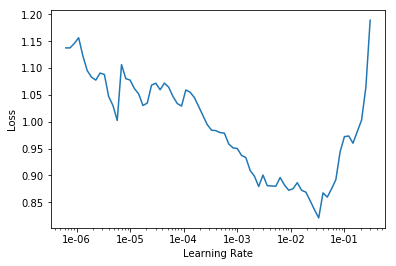

In [11]:
learn.lr_find()
learn.recorder.plot()

## Train

In [11]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.765278,0.624316,0.721393,0.835799,04:05
1,0.580342,0.434018,0.835821,0.879438,03:52
2,0.416452,0.365983,0.825871,0.907175,03:50


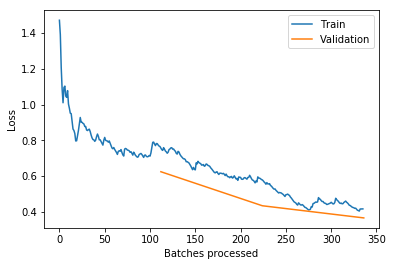

In [12]:
learn.recorder.plot_losses()

In [13]:
learn.save("seresnext50freezed")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


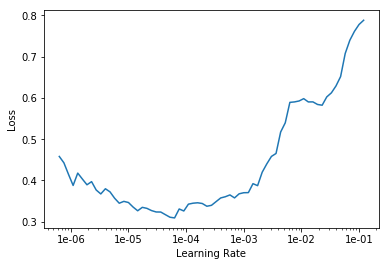

In [14]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,accuracy,AUROC,time
0,0.386917,0.358564,0.840796,0.907914,03:38
1,0.332645,0.355310,0.845771,0.911243,03:40
2,0.333127,0.355581,0.840796,0.911612,03:39


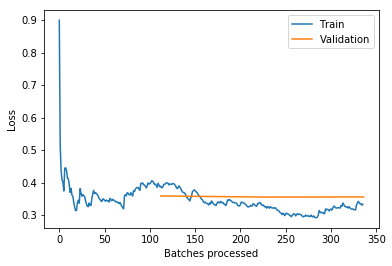

In [16]:
learn.recorder.plot_losses()

In [18]:
learn.save("seresnext50unfreezed")

# Results

In [19]:
learn.load("seresnext50unfreezed")
preds,    y    = learn.get_preds()
preds = preds[:,1].numpy()
y     = y.numpy()

In [21]:
def plot_roc(y_valid, y_pred, ax=None, figsize=(5,5)):

    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_valid, y_pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    ax.set_title('ROC Curve')
    ax.plot(fpr, tpr, 'darkorange', label = 'AUC = %0.4f' % roc_auc)
    ax.legend(loc = 'lower right', fontsize="large")
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.005, 1])
    ax.set_ylim([0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

Accuracy:  0.8407960199004975
AUC ROC:   0.911612426035503
F1 score:  0.6
Precision: 0.5
Recall:    0.75
Confusion matrix:
 [[145  24]
 [  8  24]]


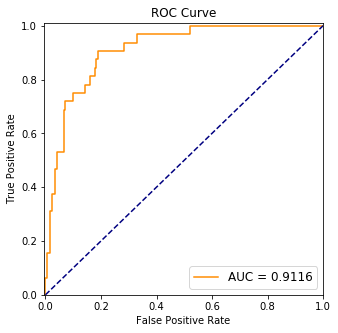

In [23]:
print("Accuracy: ", sklearn.metrics.accuracy_score(y, preds.round()))
print("AUC ROC:  ", sklearn.metrics.roc_auc_score(y, preds))
print("F1 score: ", sklearn.metrics.f1_score(y, preds.round()))
print("Precision:", sklearn.metrics.precision_score(y, preds.round()))
print("Recall:   ", sklearn.metrics.recall_score(y, preds.round()))
print("Confusion matrix:\n", sklearn.metrics.confusion_matrix(y, preds.round()))
plot_roc(y, preds);

In [26]:
weights  = torch.FloatTensor(weights2)

learn.loss_func = CrossEntropyFlat(weight=weights)

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

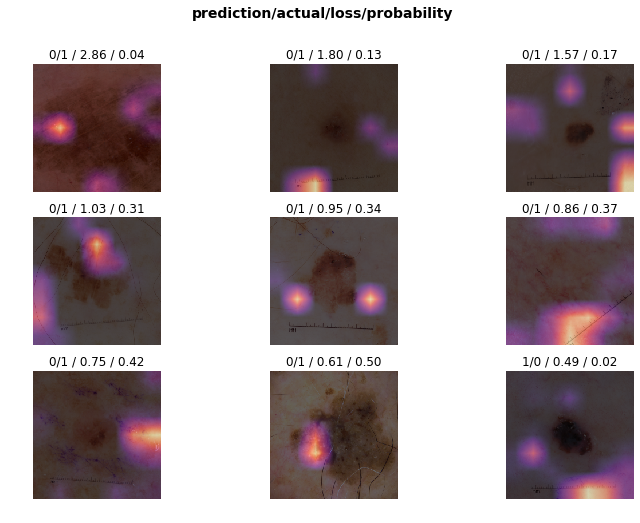

In [28]:
interp.plot_top_losses(9, figsize=(12,8))

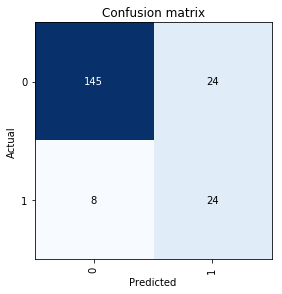

In [29]:
interp.plot_confusion_matrix()

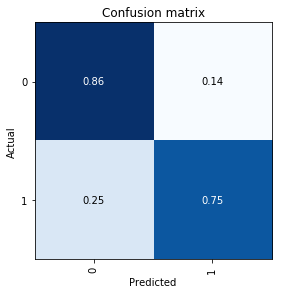

In [30]:
interp.plot_confusion_matrix(normalize=True)

In [31]:
interp.most_confused(min_val=2)

[(0, 1, 24), (1, 0, 8)]

# Extract high features (se-resnext)
The last feature vector of the model is a vector of size 512

In [10]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [14]:
################################## Get data
data = (src_train.split_none()
        .label_from_df(cols=TASK)
        .transform(([],[]), size=224)
        .databunch(bs=16, num_workers=0)
        .normalize(imagenet_stats))
        
################################## Get model

learn.load("Sebor-seresnext50unfreezed");
model    = learn.model.eval()
model[1]= model[1][:-1] # Remove last linear!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def high_features(dataset, model):
    
    num_samples = len(dataset)
    h_feats = np.empty([num_samples, 512])
    
    for i in tqdm_notebook(range(num_samples)):
        
        img_tnsr   = dataset[i][0].data.cuda()[None,:]         # [1, 3, 224, 224] cuda tensor
        h_feats[i] = model(img_tnsr)[0].cpu().detach().numpy() # [512] cpu numpy

    return h_feats

h_feats = high_features(data.train_ds, model)
np.save('../Features/sebo_seresnext.npy', h_feats)

# Fusion

In [15]:
x_low  = np.load('../Features/skinTrain_low.npy')
x_low  = sklearn.preprocessing.StandardScaler().fit_transform(x_low) # Normalice
x_high = np.load('../Features/sebo_seresnext.npy')

x = np.concatenate((x_low, x_high), axis=1)
y = pd.factorize(df_train[TASK])[0]

x_low.shape, x_high.shape

((2000, 25), (2000, 512))

# Train fusion

In [16]:
from sklearn.neural_network import MLPClassifier     # Multilayer perceptron

all_pred = np.array([])
all_real = np.array([])

for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):

    ########################################################## GET K-FOLD DATA (numpy)
    x_train, y_train = x[train_index], y[train_index]
    x_valid, y_valid = x[valid_index], y[valid_index]
        
    ########################################################## TRAIN
    model = MLPClassifier(hidden_layer_sizes=170, max_iter=1000, validation_fraction=0, random_state=0)
    model.fit(x_train, y_train)

    ########################################################## Test
    pred     = model.predict(x_valid)
    real     = y_valid
    all_pred = np.append(all_pred, pred)
    all_real = np.append(all_real, real)
    print("Fold", i+1, "  Accuracy:", sklearn.metrics.accuracy_score(real, pred))
    
print("================================")
print("Accuracy:        ",   sklearn.metrics.accuracy_score(all_real, all_pred))
print("Accuracy (balan):",   sklearn.metrics.balanced_accuracy_score(all_real, all_pred))
print("Confusion matrix:\n", sklearn.metrics.confusion_matrix(all_real, all_pred))

Fold 1   Accuracy: 0.8855721393034826
Fold 2   Accuracy: 0.9154228855721394
Fold 3   Accuracy: 0.8855721393034826
Fold 4   Accuracy: 0.9054726368159204
Fold 5   Accuracy: 0.87
Fold 6   Accuracy: 0.92
Fold 7   Accuracy: 0.9246231155778895
Fold 8   Accuracy: 0.8994974874371859
Fold 9   Accuracy: 0.8844221105527639
Fold 10   Accuracy: 0.8944723618090452
Accuracy:         0.8985
Accuracy (balan): 0.7349645083024416
Confusion matrix:
 [[1666   80]
 [ 123  131]]


# Traditional features (70ms per image)

- **Texture features**: 4 matrices * 4 features each = 16 total features
  - First acquire the 4 gray-level co-occurrence matrices
  - Then, we employ:
    - **Angular second moment** (ASM)
    - **Entropy** (ENT)
    - **Contrast** (CON)
    - **Correlation** (COR)
- **Color moment features**: For each RGB channel compute 3 features: 3x3 = 9 features
  - First color moment (**Mean**)
  - Second color moment (**Std**)
  - Third color moment (**Skewness**)

In [5]:
def low_feats(img_name):
    img    = PIL.Image.open(img_name)
    img_bw = img.convert("L")
    img_bw = np.array(img_bw)
    img    = np.array(img)

    ######### Texture feats
    glcm = skimage.feature.texture.greycomatrix(img_bw, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True)
    props = ['ASM', 'contrast', 'correlation']
    texture_feats = [skimage.feature.texture.greycoprops(glcm, prop).ravel() for prop in props]
    texture_feats.append(np.array([skimage.measure.shannon_entropy(glcm[:,:,0,d]) for d in range(4)]))

    ######### Color feats
    mean     = np.mean(img, axis=(0,1))                           # First color moment (Mean)
    std      = np.std(img, axis=(0,1))                            # Second color moment (std)
    skewness = np.array([scipy.stats.skew(img[:, :, c].reshape(-1)) for c in range(3)]) # Third color moment (Skewness)
    color_feats = [mean, std, skewness]

    return np.hstack(texture_feats + color_feats)

def save_low_feats(imageList):
    num_samples = len(imageList)
    feats = np.empty([num_samples, 25])
    
    for i in tqdm_notebook(range(num_samples)):
        feats[i] = low_feats(imageList.items[i])

    return feats

#%time low_feats(src_train.items[0])
#hist_low_feats = save_low_feats(src_train)
#np.save('skinTrain_low.npy', hist_low_feats)